In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import numpy as np
import matplotlib.pyplot as plt
#https://www.data4v.com/tutorial-hierarchical-clustering-in-spark-with-bisecting-k-means/

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
spark = SparkSession.builder \
    .appName('bisectingK') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [4]:
# Dummy table created ny AL_read_papers notebook
# Original data is first 30000 papers from 2010 with 50 assigned keywords
paps = spark.read.json("../data/processed/papers_2010/")

In [5]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

3000
2996
2310


Included all columns except title and ID since those are strings and identifiers

In [6]:
papersWIDs_woNA_woNone.columns

['11_30_Rd',
 '12_15_Ff',
 '12_38_Aw',
 '12_38_Bx',
 '12_38_Mh',
 '12_39_Fe',
 '12_60_Jv',
 '14_60_Pq',
 '95_35_+d',
 '98_80_Cq',
 'Batavia_TEVATRON_Coll',
 'Beyond_Standard_Model',
 'Brookhaven_RHIC_Coll',
 'CERN_LHC_Coll',
 'CP__violation',
 'Higgs_particle__mass',
 'None',
 'QCD',
 'background',
 'channel_cross_section',
 'citation_count',
 'coupling__Yukawa',
 'critical_phenomena',
 'dark_matter',
 'dark_matter__mass',
 'dark_matter__relic_density',
 'effective_Lagrangian',
 'field_theory__scalar',
 'finite_temperature',
 'gold',
 'heavy_ion__scattering',
 'higher-order__1',
 'minimal_supersymmetric_standard_model',
 'neutrino__mass',
 'neutrino__oscillation',
 'new_physics',
 'num_refs',
 'number_of_pages',
 'numerical_calculations',
 'numerical_calculations__Monte_Carlo',
 'p_p__inclusive_reaction',
 'parton__distribution_function',
 'potential__chemical',
 'quantum_chromodynamics',
 'quantum_chromodynamics__perturbation_theory',
 'quantum_electrodynamics',
 'quark__mass',
 'quar

In [10]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(
    inputCols=[c for c in papersWIDs_woNA_woNone.columns if not c in ['id', 'title']],
    outputCol='features')
assembled_data=assemble.transform(papersWIDs_woNA_woNone)
#assembled_data.show(2)

# Scale the Data

In [11]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
#data_scale_output.show(2)

# Fit the model

In [12]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
print("["+("".join(["."]*len(range(2,50))))+"]")
print("[", end="")
for K in range(2,50):
    print(".", end="")
    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(assembled_data)

    BKMeans_transform=BKMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

[................................................]
[................................................

Text(0, 0.5, 'Silhouette Score')

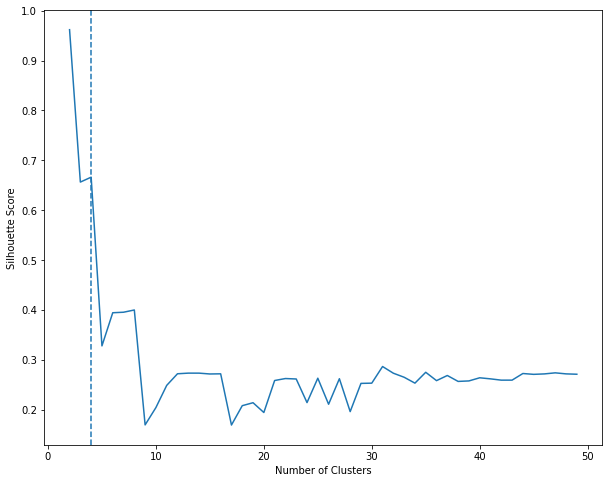

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,50),silhouette_scores)
plt.axvline(x=4, linestyle = "--")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

The predictions seem pretty stable. With k=1  clusters' sizes and centroid positions do not depend strongly on the seed

In [38]:
for seed in range(10):
    BKMeans_=BisectingKMeans(featuresCol='features', k=10, seed = seed)
    BKMeans_Model=BKMeans_.fit(assembled_data)
    BKMeans_transform=BKMeans_Model.transform(assembled_data)
    print("seed=", seed, "\t",
        list(BKMeans_Model.summary.predictions.groupby("prediction").count().sort(desc("count")).toPandas()["count"]),
        "\t",
        [round(C[0],2) for C in BKMeans_Model.clusterCenters()]
    )

seed= 0 	 [519, 495, 478, 353, 305, 122, 24, 8, 4, 2] 	 [0.07, 0.04, 0.01, 0.03, 0.01, 0.02, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 1 	 [519, 495, 478, 353, 305, 122, 26, 10, 1, 1] 	 [0.07, 0.04, 0.03, 0.01, 0.01, 0.02, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 2 	 [519, 495, 478, 353, 305, 122, 26, 10, 1, 1] 	 [0.07, 0.04, 0.03, 0.01, 0.01, 0.02, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 3 	 [518, 496, 478, 339, 305, 136, 27, 9, 1, 1] 	 [0.07, 0.04, 0.01, 0.03, 0.01, 0.01, 0.07, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 4 	 [536, 506, 470, 334, 285, 141, 24, 9, 4, 1] 	 [0.07, 0.03, 0.01, 0.03, 0.01, 0.02, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 5 	 [533, 509, 465, 353, 290, 122, 26, 7, 3, 2] 	 [0.07, 0.03, 0.03, 0.01, 0.01, 0.02, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 6 	 [519, 495, 491, 336, 292, 139, 24, 8, 4, 2] 	 [0.07, 0.04, 0.01, 0.03, 0.01, 0.01, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 7 	 [519, 495, 491, 332, 292, 143, 24, 8, 4, 2] 	 [0.07, 0.04, 0.01, 0.03, 0.01, 0.02, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


seed= 8 	 [518, 496, 478, 353, 305, 122, 24, 8, 4, 2] 	 [0.07, 0.04, 0.01, 0.03, 0.01, 0.02, 0.08, 0.0, 0.0, 0.0]
seed= 9 	 [519, 495, 478, 336, 305, 139, 24, 8, 4, 2] 	 [0.07, 0.04, 0.03, 0.01, 0.01, 0.01, 0.08, 0.0, 0.0, 0.0]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Here are meacitation counts per clusters

In [44]:
from pyspark.sql.functions import stddev, count as _count, lit

BKMeans_Model = BisectingKMeans(featuresCol='features', k=10, seed = 1).fit(assembled_data)
BKMeans_Model.summary.predictions.\
    groupby("prediction").agg(
        mean("citation_count").alias("mean"),
        stddev("citation_count").alias("sigma"),
        _count(lit(1)).alias("count")
    ).\
    sort(desc("mean"))

prediction,mean,sigma,count
9,1682.0,null,1
7,798.3,122.73643849050426,10
6,309.34615384615387,50.037539753822664,26
4,102.83852691218131,48.003071517316215,353
3,37.4655737704918,14.600140649623327,305
5,29.770491803278688,23.802835752043816,122
2,12.274058577405858,8.892922105656515,478
1,11.206060606060607,11.447908938541804,495
0,3.2427745664739884,4.5900283065017184,519
8,0.0,null,1


It could seem that the model have the prediction power (sigma<mean), but keep in mind that `citation_count` was also used as a predictor.
The result could also depend on the seed

Let us do some visuals. PCA is very usefull for this

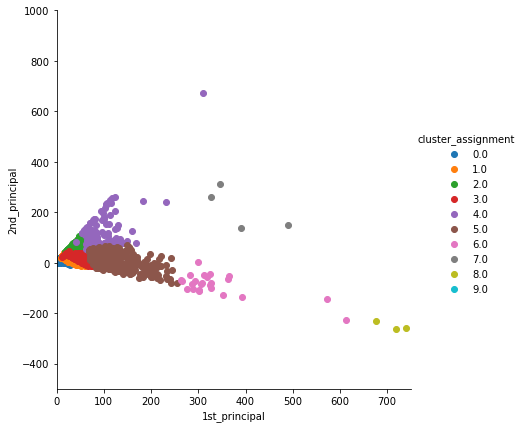

In [52]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

import numpy as np
X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)


cluster_assignment = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.xlim(0, 750)
plt.ylim(-500, 1000)
plt.show()

The clustering is evident